In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Load data

In [ ]:
main_dir = "/content/drive/MyDrive/Projects/sign_data"

In [ ]:
# Function to display a single genuine and forged signature from each of four users
def display_sample_signatures(main_dir, folder='train', user_ids=[1, 2, 3, 4]):
    plt.figure(figsize=(10, 8))

    for i, user_id in enumerate(user_ids):
        # Format user IDs to match the directory names, e.g., '001', '002'
        genuine_dir = os.path.join(main_dir, folder, f"{str(user_id).zfill(3)}")
        forged_dir = os.path.join(main_dir, folder, f"{str(user_id).zfill(3)}_forg")

        # Get any image file from each directory
        genuine_images = os.listdir(genuine_dir)
        forged_images = os.listdir(forged_dir)

        # Ensure there are images in each directory
        if genuine_images and forged_images:
            # Load one genuine and one forged image
            genuine_image_path = os.path.join(genuine_dir, genuine_images[0])
            forged_image_path = os.path.join(forged_dir, forged_images[0])

            genuine_img = cv2.imread(genuine_image_path, cv2.IMREAD_GRAYSCALE)
            forged_img = cv2.imread(forged_image_path, cv2.IMREAD_GRAYSCALE)

            # Display genuine signature
            plt.subplot(4, 2, 2 * i + 1)
            plt.imshow(genuine_img, cmap='gray')
            plt.title(f"User {str(user_id).zfill(3)} - Genuine")
            plt.axis('off')

            # Display forged signature
            plt.subplot(4, 2, 2 * i + 2)
            plt.imshow(forged_img, cmap='gray')
            plt.title(f"User {str(user_id).zfill(3)} - Forged")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

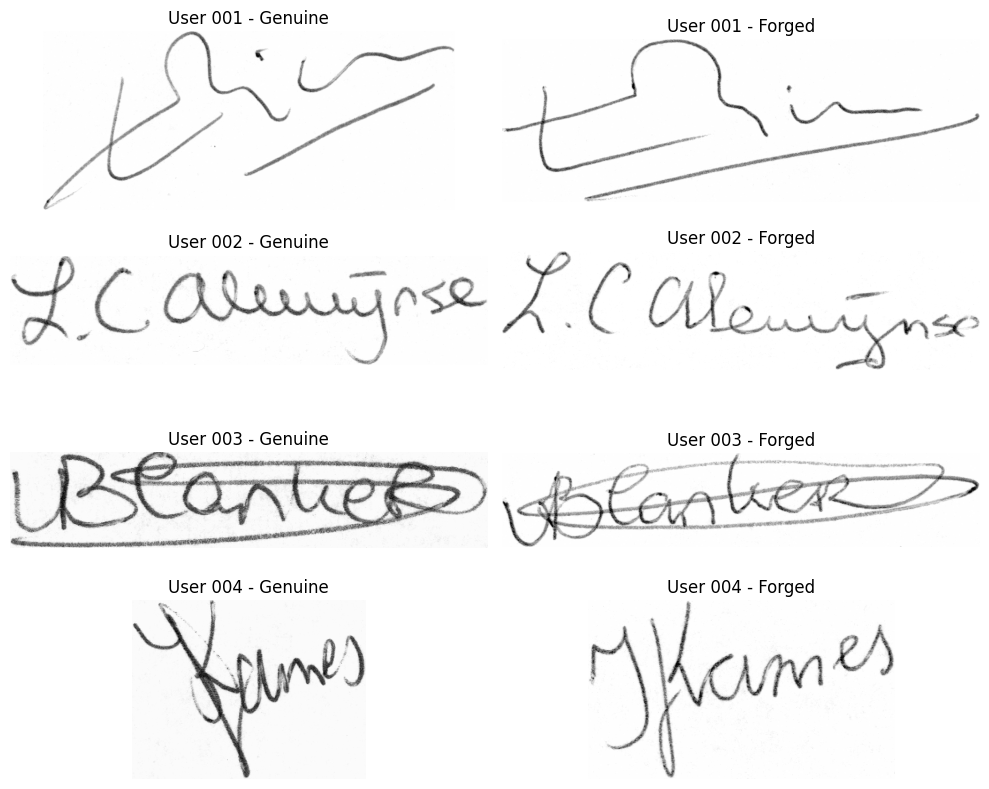

In [ ]:
# Display one genuine and one forged signature for each of four users
display_sample_signatures(main_dir, folder='train', user_ids=[1, 2, 3, 4])

In [ ]:
display_sample_signatures(main_dir, folder='test', user_ids=[49, 50, 51, 52])

In [ ]:
# Function to count images in genuine and forged directories
def count_images(main_dir, folder='train'):
    genuine_count = 0
    forged_count = 0

    # Get all subdirectories in the specified folder
    folder_path = os.path.join(main_dir, folder)
    subdirectories = os.listdir(folder_path)

    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(folder_path, subdirectory)

        # Check if it's a genuine or forged directory based on naming
        if os.path.isdir(subdirectory_path):
            if "_forg" in subdirectory:
                # Count forged images
                forged_count += len(os.listdir(subdirectory_path))
            else:
                # Count genuine images
                genuine_count += len(os.listdir(subdirectory_path))

    print(f"Total images in '{folder}' directory:")
    print(f"Genuine images: {genuine_count}")
    print(f"Forged images: {forged_count}")
    print(f"Total images: {genuine_count + forged_count}")

In [ ]:
# Count images in the train and test directories
count_images(main_dir, folder='train')

Total images in 'train' directory:
Genuine images: 887
Forged images: 762
Total images: 1649


In [ ]:
count_images(main_dir, folder='test')

Total images in 'test' directory:
Genuine images: 252
Forged images: 248
Total images: 500


In [ ]:
# Function to check image pixel sizes for 10 random images
def check_random_image_sizes(main_dir, folder='train', num_samples=10):
    folder_path = os.path.join(main_dir, folder)
    all_images = []

    # Collect all image file paths from genuine and forged directories
    for subdirectory in os.listdir(folder_path):
        subdirectory_path = os.path.join(folder_path, subdirectory)
        if os.path.isdir(subdirectory_path):
            images = [os.path.join(subdirectory_path, img) for img in os.listdir(subdirectory_path)]
            all_images.extend(images)

    # Randomly select a subset of images
    sample_images = random.sample(all_images, num_samples)

    # Print the dimensions of each selected image
    for i, image_path in enumerate(sample_images):
        img = cv2.imread(image_path)
        if img is not None:
            height, width = img.shape[:2]
            print(f"Image {i+1}: Size = {width}x{height}")
        else:
            print(f"Image {i+1}: Path = {image_path}, could not be loaded.")

In [ ]:
# Check image sizes for 10 random images in the train directory
check_random_image_sizes(main_dir, folder='train', num_samples=10)

Image 1: Size = 476x144
Image 2: Size = 723x379
Image 3: Size = 952x148
Image 4: Size = 666x286
Image 5: Size = 923x440
Image 6: Size = 577x232
Image 7: Size = 512x210
Image 8: Size = 740x184
Image 9: Size = 557x306
Image 10: Size = 559x99


In [ ]:
check_random_image_sizes(main_dir, folder='test', num_samples=10)

Image 1: Size = 814x183
Image 2: Size = 429x277
Image 3: Size = 691x266
Image 4: Size = 456x316
Image 5: Size = 668x356
Image 6: Size = 871x294
Image 7: Size = 875x364
Image 8: Size = 408x191
Image 9: Size = 696x353
Image 10: Size = 666x286


In [ ]:
# Directory paths
train_dir = f"{main_dir}/train"
test_dir = f"{main_dir}/test"

# Image dimensions
img_height, img_width = 300, 300
batch_size = 64

# Function to prepare the dataset and create a DataFrame
def create_image_dataset(directory):
    image_paths = []
    labels = []

    for folder_name in os.listdir(directory):
        if folder_name.endswith("_forg"):
            label = '1'  # Label for forged (string type)
        else:
            label = '0'  # Label for genuine (string type)

        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image_paths.append(image_path)
                labels.append(label)

    # Create a DataFrame with image paths and labels
    data = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

    # Ensure 'label' column is of string type
    data['label'] = data['label'].astype(str)

    # Shuffle the DataFrame
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle and reset index

    return data

# Prepare training and test data
train_data = create_image_dataset(train_dir)
test_data = create_image_dataset(test_dir)

# Split train data into training and validation sets (80% training, 20% validation)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Data augmentation generator for training data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1.0/255  # Rescaling to normalize the pixel values
)

# No augmentation for validation and test data, only rescaling
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Data generator for training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',  # Column with image paths
    y_col='label',       # Column with labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', # Binary classification (0 or 1)
    shuffle=True
)

# Data generator for validation data (no augmentation)
val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',  # Column with image paths
    y_col='label',       # Column with labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', # Binary classification (0 or 1)
    shuffle=False
)

# Data generator for test data (no augmentation)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',  # Column with image paths
    y_col='label',       # Column with labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', # Binary classification (0 or 1)
    shuffle=False
)

Found 1319 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [ ]:
# # Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_data['label']), y=train_data['label'])
class_weights = dict(enumerate(class_weights))

In [ ]:
from sklearn.utils import class_weight

In [ ]:
# Define CNN model
def create_cnn_model(input_shape=(300, 300, 3)):
    model = Sequential()

    # First Conv block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Second Conv block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Third Conv block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Flatten and Fully Connected layer
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    return model

# Create model
input_shape = (300, 300, 3)
model = create_cnn_model(input_shape=input_shape)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 298, 298, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 298, 298, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 149, 149, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 147, 147, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 147, 147, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 71, 71, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 71, 71, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 35, 35, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 156800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      40,141,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,235,457 (153.49 MB)

 Trainable params: 40,235,009 (153.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Assuming train_generator, val_generator, and test_generator are already defined
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
epochs = 20
cnn_history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator, class_weight=class_weights, callbacks=[early_stopping]
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9120 - loss: 0.2421 - val_accuracy: 0.5000 - val_loss: 219.6264
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9192 - loss: 0.2523 - val_accuracy: 0.5000 - val_loss: 255.6852
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9351 - loss: 0.1777 - val_accuracy: 0.5000 - val_loss: 229.3627
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9157 - loss: 0.1797 - val_accuracy: 0.5000 - val_loss: 195.8433
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9301 - loss: 0.1371 - val_accuracy: 0.5000 - val_loss: 140.6716
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9410 - loss: 0.1497 - val_accuracy: 0.5000 - val_loss: 94.4466
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9574 - loss: 0.1095 - val_accuracy: 0.5000 - val_loss: 107.7784
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9241 - loss: 0.1995 - val_accuracy: 0.500

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 487ms/step - accuracy: 0.8730 - loss: 0.8922
Test Loss: 0.9842575788497925
Test Accuracy: 0.8600000143051147


In [ ]:
def plot_training_history(history, title="Model Training History"):
    # Extract accuracy and loss values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

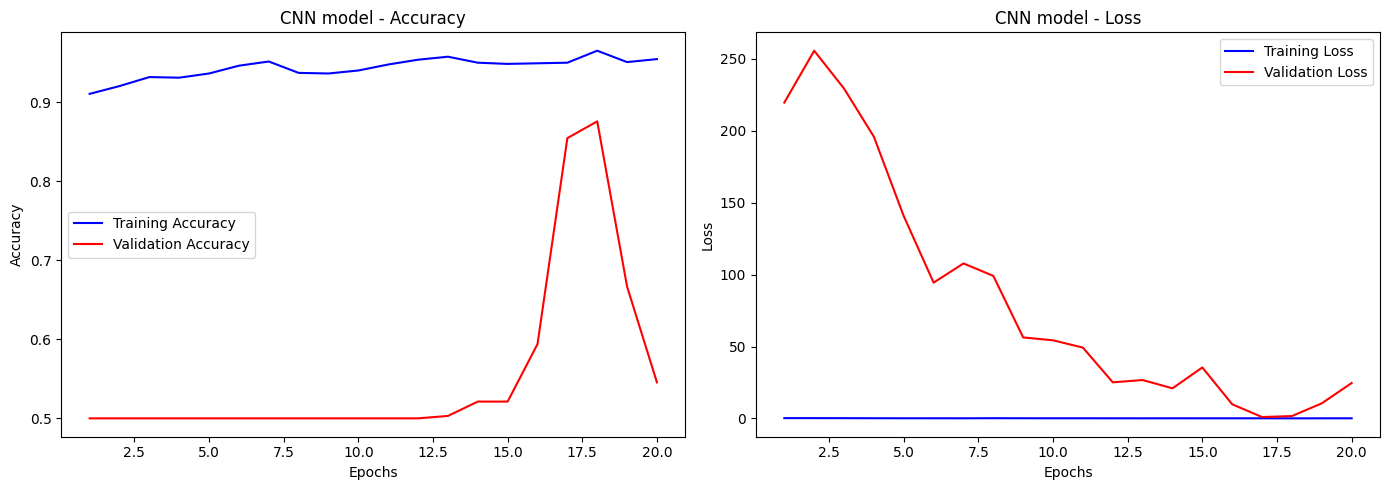

In [ ]:
plot_training_history(cnn_history, 'CNN model')

In [ ]:
def evaluate_model(model, test_generator, title):
    # Get predictions and true labels
    test_generator.reset()
    predictions = model.predict(test_generator)

    # For binary classification, use threshold 0.5 to get predicted classes
    predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to 0 or 1

    # Get true labels from the generator's classes attribute
    true_classes = test_generator.classes
    class_names = ["Genuine", "Forged"]

    # Generate classification report
    print("Classification Report:")
    report = classification_report(true_classes, predicted_classes, target_names=class_names)
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{title} Confusion Matrix')
    plt.show()

    return cm

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step
Classification Report:
              precision    recall  f1-score   support

     Genuine       0.78      1.00      0.88       252
      Forged       1.00      0.72      0.84       248

    accuracy                           0.86       500
   macro avg       0.89      0.86      0.86       500
weighted avg       0.89      0.86      0.86       500



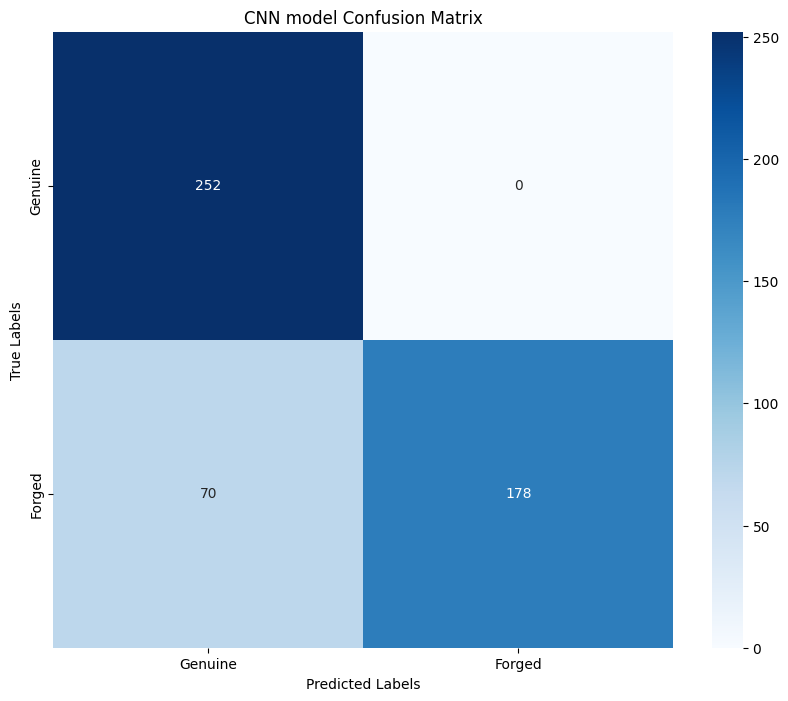

array([[252,   0],
       [ 70, 178]])

In [ ]:
evaluate_model(model, test_generator,'CNN model')

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

def create_vgg16_model(input_shape=(300, 300, 3)):
    # Create an input tensor
    input_tensor = Input(shape=input_shape)

    # Load the VGG16 model with pre-trained ImageNet weights, excluding the top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Freeze all layers of the VGG16 model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers for binary classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Reduce dimensions using global average pooling
    x = Dense(256, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.5)(x)  # Dropout for regularization
    predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification

    # Create the final model
    model = Model(inputs=input_tensor, outputs=predictions)

    return model

# Create the model
input_shape = (300, 300, 3)  # Ensure this matches your image dimensions
model_vgg16 = create_vgg16_model(input_shape=input_shape)

# Compile the model
model_vgg16.compile(optimizer=Adam(),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model_vgg16.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 300, 300, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 300, 300, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 150, 150, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 150, 150, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 75, 75, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 75, 75, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 75, 75, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 37, 37, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 37, 37, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 18, 18, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
vgg_history = model_vgg16.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator, class_weight=class_weights, callbacks=[early_stopping]
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.5506 - loss: 0.7004 - val_accuracy: 0.7606 - val_loss: 0.6075
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6603 - loss: 0.6141 - val_accuracy: 0.7667 - val_loss: 0.5580
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7169 - loss: 0.5657 - val_accuracy: 0.8030 - val_loss: 0.5090
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7338 - loss: 0.5424 - val_accuracy: 0.8364 - val_loss: 0.4633
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7894 - loss: 0.4853 - val_accuracy: 0.8576 - val_loss: 0.4243
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8285 - loss: 0.4397 - val_accuracy: 0.8758 - val_loss: 0.3967
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8386 - loss: 0.4170 - val_accuracy: 0.8667 - val_loss: 0.3713
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8339 - loss: 0.3892 - val_accuracy: 0.8879 - val_loss

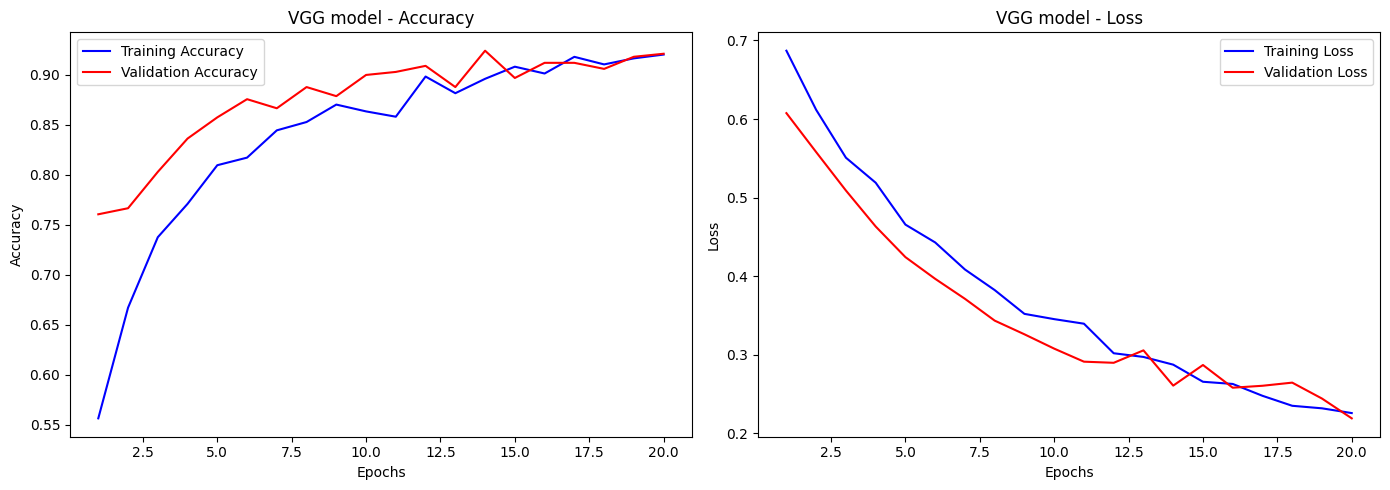

In [ ]:
plot_training_history(vgg_history, 'VGG model')

8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step
Classification Report:
              precision    recall  f1-score   support

     Genuine       0.96      0.85      0.90       252
      Forged       0.86      0.96      0.91       248

    accuracy                           0.90       500
   macro avg       0.91      0.90      0.90       500
weighted avg       0.91      0.90      0.90       500



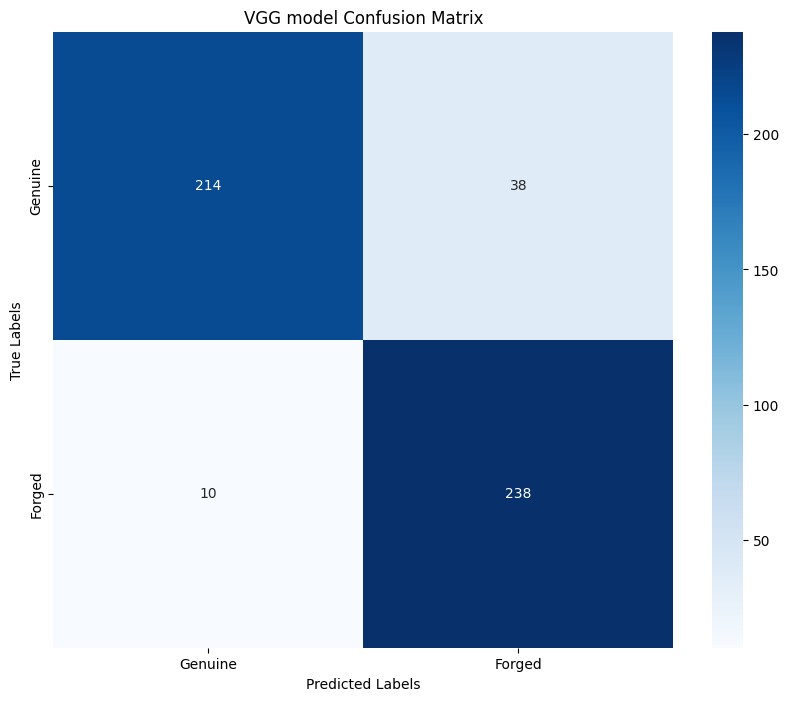

array([[214,  38],
       [ 10, 238]])

In [ ]:
evaluate_model(model_vgg16, test_generator,'VGG model')